In [1]:
import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import zarr
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from natsort import natsorted
import matplotlib.pyplot as plt
%matplotlib inline

BASE_PATH = Path("/scratch/ventricle_dataset/train")

def custom_collate(batch):
    images, labels, slices_points, lbl_pts = zip(*batch)
    concatenated_images = np.concatenate([np.expand_dims(img, axis=0) for img in images]) #torch.cat([img.unsqueeze(0) for img in images], dim=0)
    concatenated_labels = np.concatenate([np.expand_dims(lbl, axis=0) for lbl in labels])# torch.cat([lbl.unsqueeze(0) for lbl in labels], dim=0)
    slices_points = tuple([np.array(pts) for pts in slices_points])
    lbl_pts = tuple([np.array(lbl_pt) for lbl_pt in lbl_pts])
    return concatenated_images, concatenated_labels, slices_points, lbl_pts
    

class NumpyDataset(Dataset):
    def __init__(self, image_path, labels_path, points, transform=None):
        """
        Args:
            images (list or numpy array): List of images as NumPy arrays.
            labels (list or numpy array): List of labels as NumPy arrays or other formats.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.labels_paths = natsorted(
            [str(p.name) for p in list(Path(image_path).glob("*.npy"))]
        )
        self.image_base_path = Path(image_path)
        self.labels_base_path = Path(labels_path)
        self.points = points.copy()
        self.transform = transform

    def __len__(self):
        return len(self.labels_paths)

    def __getitem__(self, idx):
        path = self.labels_paths[idx]
        slice_idx = int(path.split('_')[-1].replace('.npy', ''))
        slice_points = self.points[self.points[:, 0] == slice_idx]
        if not slice_points.shape[0]:
            raise ValueError(f"Problem getting points from image {path} {slice_idx}")

        slice_points = slice_points[:, 1:]
        image = np.load(self.image_base_path.joinpath(self.labels_paths[idx])).astype(np.float32)
        label = np.load(self.labels_base_path.joinpath(self.labels_paths[idx])).astype(np.uint8)

        if self.transform:
            augmented_data = self.transform(image=image, mask=label, keypoints=slice_points)
            image = augmented_data['image'].detach().cpu().numpy()
            label = augmented_data['mask'].detach().cpu().numpy()
            slice_points = augmented_data['keypoints']

        else:
            image = np.expand_dims(image, axis=0)
        # if not isinstance(image, torch.Tensor):
        #     image = torch.tensor(image[np.newaxis, ...], dtype=torch.float32)

        # if not isinstance(label, torch.Tensor):
        #     label = torch.tensor(label, dtype=torch.long)

        image = image.transpose( (1,2,0) )
        image = np.concatenate([image]*3, axis=-1)
        # print(image.shape, label.shape,image.dtype, label.dtype, len(slice_points), slice_points)
        return image, label, slice_points, np.array([1]*len(slice_points))

/opt/conda/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [2]:
from albumentations.pytorch import ToTensorV2
import albumentations as A

augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    # A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.5),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='yx', remove_invisible=True))

In [3]:
points = np.load(BASE_PATH.joinpath('points/smartspim_693196_vs_pts.npy'))
ventricle_dataset = NumpyDataset(
    image_path=BASE_PATH.joinpath('images'),
    labels_path=BASE_PATH.joinpath('labels'),
    points=points,
    transform=None#augmentations
)

In [4]:
dataloader = DataLoader(ventricle_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate)

0.0 255.0 (1024, 1024, 3)


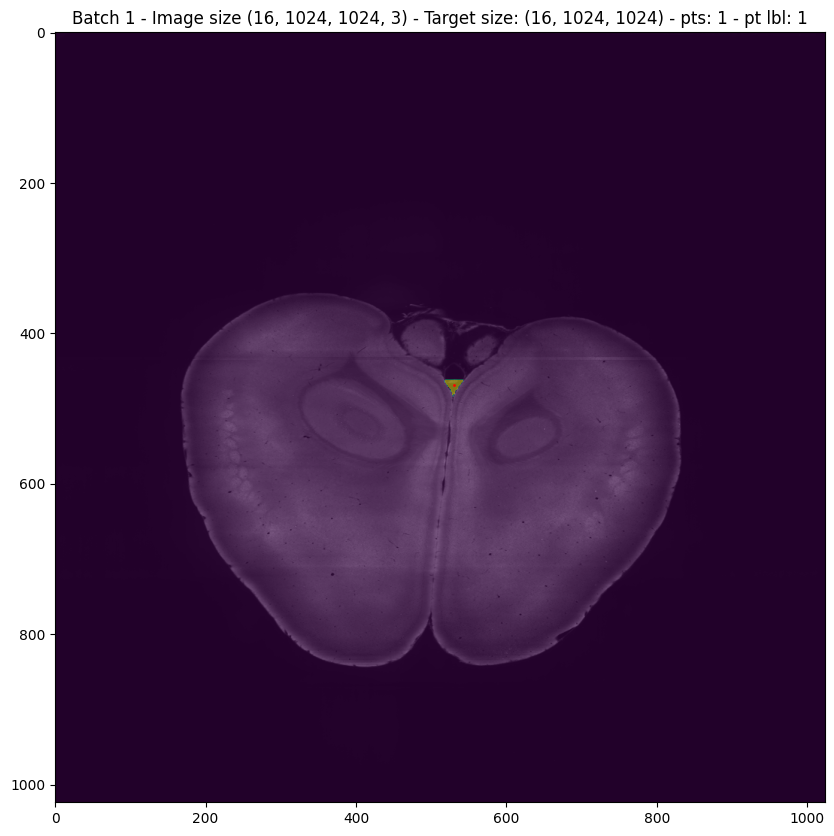

0.0 255.0 (1024, 1024, 3)


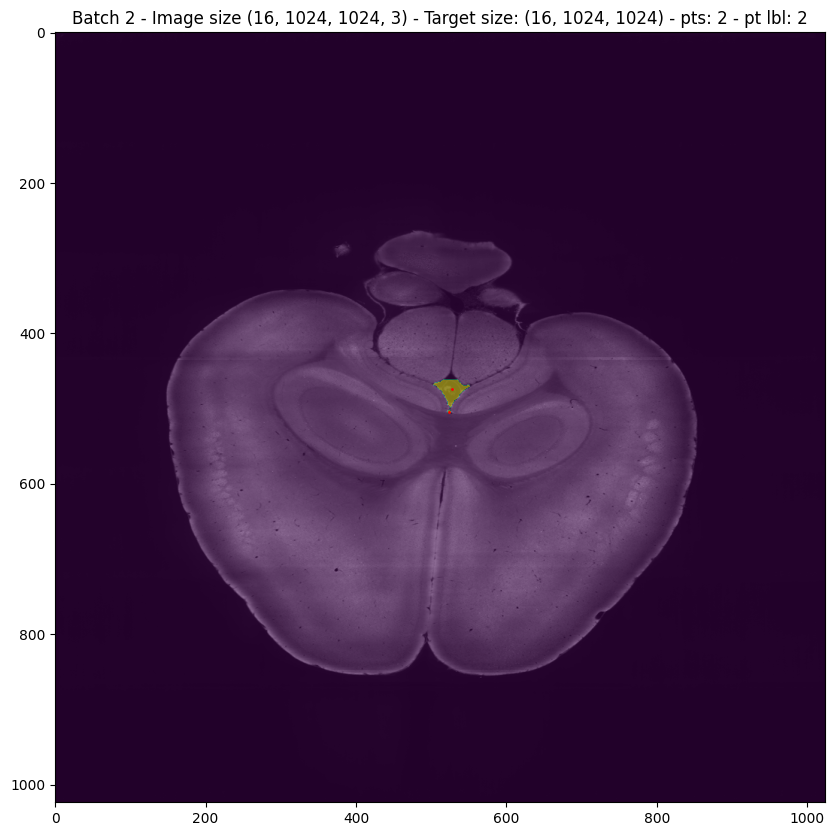

0.0 255.0 (1024, 1024, 3)


KeyboardInterrupt: 

In [5]:
limit = 1
for batch_idx, (data, target, slices_points, pts_lbls) in enumerate(dataloader):
    idx = -1
    slc_pts = slices_points[idx]
    pt_lbl = pts_lbls[idx]

    print(data[idx].min(), data[idx].max(), data[idx].shape)
    
    plt.figure(figsize=(10,10))
    plt.imshow(data[idx][..., 1], cmap="gray")
    plt.imshow(target[idx], alpha=0.5)
    plt.scatter(slc_pts[:, 1], slc_pts[:, 0], c='red', s=1)
    plt.title(f"Batch {batch_idx + 1} - Image size {data.shape} - Target size: {target.shape} - pts: {len(slc_pts)} - pt lbl: {pt_lbl.shape[0]}")
    plt.show()

    if batch_idx == 10:
        break

In [12]:
sam2_checkpoint = "./segment-anything-2/checkpoints/sam2_hiera_small.pt"
model_cfg = "sam2_hiera_s.yaml" #"sam2_hiera_s.yaml"#

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda") # load model
predictor = SAM2ImagePredictor(sam2_model)

In [14]:
lr = 1e-5
wd = 4e-5

predictor.model.sam_mask_decoder.train(True) # enable training of mask decoder
predictor.model.sam_prompt_encoder.train(True) # enable training of prompt encoder
optimizer=torch.optim.Adam(params=predictor.model.parameters(),lr=lr,weight_decay=wd)

scaler = torch.cuda.amp.GradScaler()
device = torch.device(0)

In [19]:
from torch.nn import CrossEntropyLoss
from torchmetrics.segmentation import MeanIoU

miou_metric = MeanIoU(
    num_classes=1,
    # include_background=True,
    # per_class=True
).to(device)
mean_iou = 0

loss = CrossEntropyLoss(reduction='mean')
best_loss = 0.0
epochs = 10

for itr in range(epochs):
    with torch.cuda.amp.autocast():
        for batch_idx, (data, target, slices_points, pts_lbls) in enumerate(dataloader):
            for i in range(data.shape[0]):
                curr_slice = data[i, ...]
                curr_mask = target[i, ...]
                slice_points = slices_points[i]
                slices_lbls = pts_lbls[i]
                
                # print(curr_slice.shape, curr_mask.shape, slice_points.shape, slices_lbls.shape)
                predictor.set_image(curr_slice)
        
                # prompt encoding
                mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                    slice_points,
                    slices_lbls,
                    box=None,
                    mask_logits=None,
                    normalize_coords=True
                )
                sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                    points=(
                        unnorm_coords,
                        labels
                    ),
                    boxes=None,
                    masks=None,
                )
        
                # mask decoder
                batched_mode = unnorm_coords.shape[0] > 1 # multi object prediction
                high_res_features = [
                    feat_level[-1].unsqueeze(0)
                    for feat_level in predictor._features["high_res_feats"]
                ]
                low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                    image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                    image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=True,
                    repeat_image=batched_mode,
                    high_res_features=high_res_features,
                )
                prd_masks = predictor._transforms.postprocess_masks(
                    low_res_masks,
                    predictor._orig_hw[-1]
                )# Upscale the masks to the original image resolution
    
                # show_pred_mask = prd_masks.detach().cpu().numpy().squeeze()
                # show_pred_mask = show_pred_mask.transpose((1,2,0))
                # print("Pred mask: ", show_pred_mask.shape)
                # plt.imshow(show_pred_mask)
                # plt.show()
                # s
                
                # Loss calculation
                gt_mask = torch.tensor(
                    curr_mask[np.newaxis, ...].astype(np.float32)
                ).cuda()
    
                # Turning logits to prob map
                prd_mask = torch.sigmoid(prd_masks[:, 0])
                
                seg_loss = (
                    -gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)
                ).mean()
    
                # print("Seg loss: ", seg_loss, " prd: ", prd_mask.shape, " gt ", gt_mask.shape, prd_mask, gt_mask)
                # seg_loss = loss(prd_mask, gt_mask)
        
                # Score loss calculation (intersection over union) IOU
                prd_mask_iou = prd_mask.clone()[None, ...]
                gt_mask_iou = gt_mask.clone()[None, ...]
                prd_mask_iou[prd_mask_iou > 0.5] = 1
                
                iou = miou_metric(prd_mask_iou.to(torch.uint8), gt_mask_iou.to(torch.uint8))
                
                score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
                loss=seg_loss + score_loss*0.05  # mix losses
            
            # print("Torch metric IoU: ", itr, iou)
    
            # apply back propogation
                predictor.model.zero_grad() # empty gradient
                scaler.scale(loss).backward()  # Backpropogate
                scaler.step(optimizer)
                scaler.update() # Mix precision
    
            if itr%1000==0: torch.save(predictor.model.state_dict(), f"model_{itr}.torch");print("save model")
    
            # Display results
    
            if itr==0:
                mean_iou=0
                mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
            
            print("step)",itr, "Accuracy(IOU)=",mean_iou)

save model
step) 0 Accuracy(IOU)= 0.0
save model
step) 0 Accuracy(IOU)= 0.00014822134748101234
save model
step) 0 Accuracy(IOU)= 3.286230785306543e-06
save model
step) 0 Accuracy(IOU)= 4.865860100835562e-05
save model
step) 0 Accuracy(IOU)= 1.7830608703661711e-06
save model
step) 0 Accuracy(IOU)= 0.00013749097473919391
save model
step) 0 Accuracy(IOU)= 0.00028488269075751307
save model
step) 0 Accuracy(IOU)= 0.000341772548854351
save model
step) 0 Accuracy(IOU)= 0.0002564670145511627
save model
step) 0 Accuracy(IOU)= 0.00016085790470242502
save model
step) 0 Accuracy(IOU)= 1.8716577906161546e-05
save model
step) 0 Accuracy(IOU)= 8.311805315315724e-05
save model
step) 0 Accuracy(IOU)= 0.0003524818271398544
save model
step) 0 Accuracy(IOU)= 0.0004476594552397728
save model
step) 0 Accuracy(IOU)= 0.0004985262826085091
save model
step) 0 Accuracy(IOU)= 0.000136239780113101
save model
step) 0 Accuracy(IOU)= 0.00014117022044956684
save model
step) 0 Accuracy(IOU)= 9.926105849444867e-06
save 

KeyboardInterrupt: 

In [18]:
for batch_idx, (data, target, slices_points, pts_lbls) in enumerate(dataloader):
    curr_slice = data[-1]
    predictor.set_image(curr_slice)
        
    # prompt encoding
    mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
        slice_points,
        slices_lbls,
        box=None,
        mask_logits=None,
        normalize_coords=True
    )
    sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
        points=(
            unnorm_coords,
            labels
        ),
        boxes=None,
        masks=None,
    )
    
    # mask decoder
    batched_mode = unnorm_coords.shape[0] > 1 # multi object prediction
    high_res_features = [
        feat_level[-1].unsqueeze(0)
        for feat_level in predictor._features["high_res_feats"]
    ]
    low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
        image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
        image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=True,
        repeat_image=batched_mode,
        high_res_features=high_res_features,
    )
    prd_masks = predictor._transforms.postprocess_masks(
        low_res_masks,
        predictor._orig_hw[-1]
    )
    curr_slice_cpu = curr_slice
    prd_masks_cpu = prd_masks.detach().cpu().numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(curr_slice_cpu, cmap="gray")
    plt.imshow(prd_masks_cpu[0, 0, ...], alpha=0.7)
    plt.show()
    break

/opt/conda/lib/python3.10/site-packages/sam2/sam2_image_predictor.py:314: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  point_coords = torch.as_tensor(


ValueError: expected sequence of length 2 at dim 1 (got 3)